## This Notebook trains a Neural Network for Galaxy-Matter-Powerspektra Predictions

In [1]:
import g3lhalo
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np
import random
from pyDOE import lhs
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_addons as tfa
import optuna
from tensorflow.keras.layers import LeakyReLU, ELU

# Für spezielle Aktivierungen wie Swish, GELU
try:
    from tensorflow.keras.activations import swish, gelu
except ImportError:
    # Alternative falls alte TensorFlow-Version
    def swish(x): return x * tf.nn.sigmoid(x)
    def gelu(x): return 0.5 * x * (1.0 + tf.tanh(tf.sqrt(2.0 / tf.constant(np.pi)) * (x + 0.044715 * tf.pow(x, 3))))

# Für AdamW und RAdam Optimizer:
try:
    from tensorflow_addons.optimizers import AdamW, RectifiedAdam
except ImportError:
    # Falls nicht installiert:
    # pip install tensorflow-addons
    print("Installiere tensorflow-addons mit: pip install tensorflow-addons")

2025-07-06 11:36:02.992756: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 11:36:02.996148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-06 11:36:03.058194: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-06 11:36:03.059995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-06 11:36:06.116831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
#%pip install tensorflow
#%pip install pyDOE
#%pip install pandas
#%pip install seaborn
#%pip install tensorflow-addons
#%pip install filelock
#%pip install pyccl

In [3]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
using cpu device 



In [4]:
# setting the seed for reproducibility
np.random.seed(9721)
tf.random.set_seed(9721)

In [5]:
# Get test/training split

N_total=1000000 # Total samples
f_val = 0.000001
f_train=0.000001
f_test= 1-f_val-f_train

# Calculate test and train sample counts
N_test = int(f_test * N_total)
N_train = int(f_train * N_total)
N_val = int(f_val * N_total)

# Generate indices
indices = np.arange(N_total)
np.random.shuffle(indices)

testing_indices=indices[:N_test]
validation_indices = indices[N_test:N_test+N_val]
training_indices = indices[N_test+N_val:N_total]

print(f"Number of test samples is {len(testing_indices)}, should be {N_test}")
print(f"Number of validation samples is {len(validation_indices)}, should be {N_val}")

print(f"Number of train samples is {len(training_indices)}, should be {N_train}")

Number of test samples is 999998, should be 999998
Number of validation samples is 1, should be 1
Number of train samples is 1, should be 1


/tmp/ipykernel_2647974/58162579.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


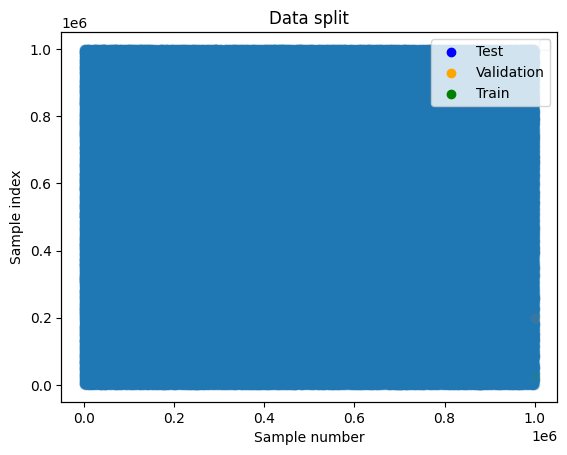

In [6]:
# Plot of test_indices and train_indices
fig, axes=plt.subplots()

plt.scatter(range(N_test), testing_indices, alpha=0.1)
plt.scatter(np.arange(N_val)+N_test, validation_indices, alpha=0.1)
plt.scatter(np.arange(N_train)+N_test+N_val, training_indices, alpha=0.1)

plt.title('Data split')

plt.xlabel('Sample number')
plt.ylabel('Sample index')

ax2=axes.twinx()
ax2.scatter(np.NaN, np.NaN, label='Test', color='blue')
ax2.scatter(np.NaN, np.NaN, label='Validation', color='orange')
ax2.scatter(np.NaN, np.NaN, label='Train', color='green')
ax2.set_yticks([])

axes.legend()
ax2.legend(loc='upper right')
#plt.savefig('../Plots/DataSplit.png', dpi=600)


## Read in generated Targets

In [7]:
# Create directory to save the generated data
data_dir = "../Data/"
os.makedirs(data_dir, exist_ok=True)

In [8]:
# Specifying the storage location of the data
data_dir = "../Data/"

# File path to the saved JSON file
data_fn = f"{data_dir}GeneratedData_1000000_2025-06-11_05-16-31.json"
# read in data
with open(data_fn, "r") as json_file:
    data_samples = json.load(json_file)

# Define keys needed for Galaxie-Matter
target_keys = [ 
    'Pk_sl_1h', 'Pk_sl_2h', 'Pk_sl'
]

# Create numpy arrays for each of the Pk_* columns
targets_array = {key: np.array([sample[key] for sample in data_samples]) for key in target_keys}


# Logarithmic transformation of the data
def log_transform(targets_array):
    return {key: np.log(data) for key, data in targets_array.items()}

# Calculate logarithms of the data
log_transformed_data = log_transform(targets_array)

# Split the data into training, test and validation sets
training_targets = {}
testing_targets = {}
validation_targets = {}

# Convert dictionaries to NumPy arrays
training_targets['modes'] = np.array([data[:][training_indices] for data in targets_array.values()])
training_targets['targets'] = np.array([data[:][training_indices] for data in log_transformed_data.values()])

validation_targets['modes'] = np.array([data[:][validation_indices] for data in targets_array.values()])
validation_targets['targets'] = np.array([data[:][validation_indices] for data in log_transformed_data.values()])

testing_targets['modes'] = np.array([data[:][testing_indices] for data in targets_array.values()])
testing_targets['targets'] = np.array([data[:][testing_indices] for data in log_transformed_data.values()])

# Define keys needed for linear term
lin_keys = [ 
    'Pk_lin'
]

# Create numpy arrays for linear term
lin_array = {key: np.array([sample[key] for sample in data_samples]) for key in lin_keys}

# Split the linear term data into training, test and validation sets
lin_training_targets = {}
lin_testing_targets = {}
lin_validation_targets = {}

# Convert dictionaries to NumPy arrays
lin_training_targets['modes'] = np.array([data[:][training_indices] for data in lin_array.values()])
lin_training_targets['targets'] = np.array([data[:][training_indices] for data in log_transformed_data.values()])

lin_validation_targets['modes'] = np.array([data[:][validation_indices] for data in lin_array.values()])
lin_validation_targets['targets'] = np.array([data[:][validation_indices] for data in log_transformed_data.values()])

lin_testing_targets['modes'] = np.array([data[:][testing_indices] for data in lin_array.values()])
lin_testing_targets['targets'] = np.array([data[:][testing_indices] for data in log_transformed_data.values()])

In [9]:
print('number of training targets:', len(training_targets['modes'][:][0]), '. Should be', N_train)
print('number of validation targets:', len(validation_targets['modes'][:][0]), '. Should be', N_val)

print('number of test targets:', len(testing_targets['modes'][:][0]), '. Should be', N_test)

number of training targets: 1 . Should be 1
number of validation targets: 1 . Should be 1
number of test targets: 999998 . Should be 999998


In [10]:
N_modes=len(training_targets['modes'])
print(f"Shape of training targets: {training_targets['targets'].shape}. Should be ({N_modes}, {N_train}, 50)")
print(f"Shape of testing targets: {testing_targets['targets'].shape}. Should be ({N_modes}, {N_test}, 50)")
print(f"Shape of validation targets: {validation_targets['targets'].shape}. Should be ({N_modes}, {N_val}, 50)")

Shape of training targets: (3, 1, 50). Should be (3, 1, 50)
Shape of testing targets: (3, 999998, 50). Should be (3, 999998, 50)
Shape of validation targets: (3, 1, 50). Should be (3, 1, 50)


## Read in lin

In [11]:
#print('number of training targets:', len(lin_training_targets['modes'][:][0]), '. Should be', N_train)
#print('number of validation targets:', len(lin_validation_targets['modes'][:][0]), '. Should be', N_val)

#print('number of test targets:', len(lin_testing_targets['modes'][:][0]), '. Should be', N_test)

In [12]:
N_modes=len(lin_training_targets['modes'])
#print(f"Shape of training targets: {lin_training_targets['modes'].shape}. Should be ({N_modes}, {N_train}, 50)")
#print(f"Shape of testing targets: {lin_testing_targets['modes'].shape}. Should be ({N_modes}, {N_test}, 50)")
#print(f"Shape of validation targets: {lin_validation_targets['modes'].shape}. Should be ({N_modes}, {N_val}, 50)")

## Read in related features

In [13]:
para_fn = f"{data_dir}Parameter_1000000_2025-06-11_05-16-31.json"
# Read in
with open(para_fn, "r") as json_file:
    samples = json.load(json_file)


# Create numpy arrays for each of the parameter columns
feature_keys = ['Om_c', 'Om_b', 'h', 'sigma_8', 'n_s', 'alpha', 'sigma', 'Mth', 'Mprime', 'beta']

# List of arrays for each parameter
feature_array = {key: np.array([sample[key] for sample in samples]) for key in feature_keys}

# Split features into training, validation and test data
training_features = {key: feature[training_indices] for key, feature in feature_array.items()}
validation_features = {key: feature[validation_indices] for key, feature in feature_array.items()}
testing_features = {key: feature[testing_indices] for key, feature in feature_array.items()}

training_features = np.array(list(zip(*training_features.values())))
validation_features = np.array(list(zip(*validation_features.values())))
testing_features = np.array(list(zip(*testing_features.values())))


In [14]:
log_indices = [7, 8]  # Ersetze mit deinen echten Indizes

training_features[:, log_indices] = np.log10(training_features[:, log_indices])
validation_features[:, log_indices] = np.log10(validation_features[:, log_indices])
testing_features[:, log_indices] = np.log10(testing_features[:, log_indices])

print("input min/max:", training_features.min(), training_features.max())

input min/max: 0.03593945704267147 15.89002935753064


In [15]:
print('number of training features:', len(training_features), '. Should be', N_train)
print('number of validation features:', len(validation_features), '. Should be', N_val)

print('number of test features:', len(testing_features), '. Should be', N_test)

number of training features: 1 . Should be 1
number of validation features: 1 . Should be 1
number of test features: 999998 . Should be 999998


## Cross check
Now, for a cross check we plot the mean of the training, testing and validation data sets. These should all look roughly the same, otherwise we have selected strange test and validation sets.

In [16]:
mean_training_targets = []
std_training_targets = []

mean_testing_targets = []
std_testing_targets = []

mean_validation_targets = []
std_validation_targets = []

# Calculate mean and standard deviation for training targets
for i in range(len(training_targets['modes'])):  # for all 3-Halo terms
    halo_data = np.array(training_targets['targets'][i])
    
    mean = np.mean(halo_data, axis=0)  # mean over complete training sample for every k-value
    std = np.std(halo_data, axis=0)    # standard deviation over complete training sample for every k-value
    
    mean_training_targets.append(mean)
    std_training_targets.append(std)

# Calculate mean and standard deviation for testing targets
for i in range(len(testing_targets['modes'])):  # for all 3-Halo terms
    halo_data = np.array(testing_targets['targets'][i])

    mean = np.mean(halo_data, axis=0) # mean over complete testing sample for every k-value
    std = np.std(halo_data, axis=0)    # standard deviation over complete testing sample for every k-value

    mean_testing_targets.append(mean)
    std_testing_targets.append(std)

# Calculate mean and standard deviation for validation targets
for i in range(len(validation_targets['modes'])):  # for all 3-Halo terms
    halo_data = np.array(validation_targets['targets'][i])

    mean = np.mean(halo_data, axis=0)  # mean over complete validation sample for every k-value
    std = np.std(halo_data, axis=0)    # standard deviation over complete validation sample for every k-value

    mean_validation_targets.append(mean)
    std_validation_targets.append(std)


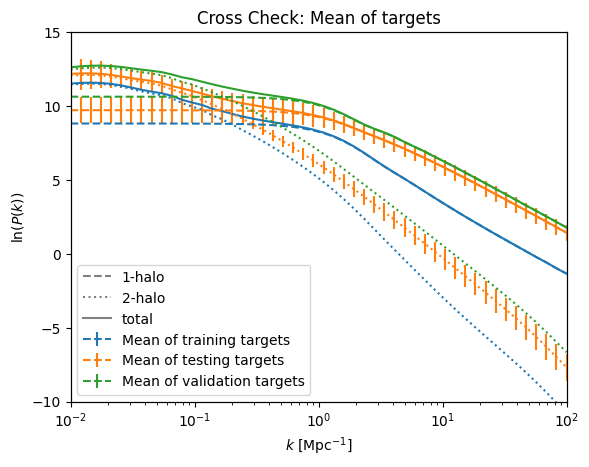

In [17]:
ks = np.geomspace(1e-2, 1e2)

fig, axes=plt.subplots()

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\ln(P(k))$')
plt.title('Cross Check: Mean of targets')


ax2=axes.twinx()
ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='grey')




ax2.legend(loc='lower left')


plt.xlim(1e-2,100)
plt.ylim(-10, 15)
axes.set_ylim(-10, 15)
ax2.set_yticks([])
axes.set_xscale('log')
axes.set_yscale('linear')


# Plot training targets
plt.errorbar(ks, mean_training_targets[0], ls='--',
             yerr=std_training_targets[0], color='C0', label='Mean of training targets', fmt='')
plt.errorbar(ks, mean_training_targets[1], ls=':', 
             yerr= std_training_targets[1], color='C0', fmt='')
plt.errorbar(ks, mean_training_targets[2], 
             yerr=std_training_targets[2], color='C0', fmt='')

# Plot testing targets
plt.errorbar(ks, mean_testing_targets[0]+0.5, ls='--',
             yerr=std_testing_targets[0], color='C1', label='Mean of testing targets', fmt='')
plt.errorbar(ks, mean_testing_targets[1]+0.5, ls=':', 
             yerr= std_testing_targets[1], color='C1', fmt='')
plt.errorbar(ks, mean_testing_targets[2]+0.5, 
             yerr=std_testing_targets[2], color='C1', fmt='')

# Plot validation targets
plt.errorbar(ks, mean_validation_targets[0]+1, ls='--',
             yerr=std_validation_targets[0], color='C2', label='Mean of validation targets', fmt='')
plt.errorbar(ks, mean_validation_targets[1]+1, ls=':', 
             yerr= std_validation_targets[1], color='C2', fmt='')
plt.errorbar(ks, mean_validation_targets[2]+1, 
             yerr=std_validation_targets[2], color='C2', fmt='')

plt.legend()
plt.savefig('../Plots/CrossCheckTargets.png', dpi=600)
plt.show()

In [18]:
mean_training_features = []
std_training_features = []

mean_testing_features = []
std_testing_features = []

mean_validation_features = []
std_validation_features = []

# Calculate mean and standard deviation for training features
for i in range(len(training_features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(training_features[:,i])
    
    mean = np.mean(feature_parameter, axis=0)  # mean over complete training sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete training sample for every k-value
    
    mean_training_features.append(mean)
    std_training_features.append(std)

# Calculate mean and standard deviation for testing features
for i in range(len(testing_features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(testing_features[:,i])

    mean = np.mean(feature_parameter, axis=0) # mean over complete testing sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete testing sample for every k-value

    mean_testing_features.append(mean)
    std_testing_features.append(std)

# Calculate mean and standard deviation for validation features
for i in range(len(validation_features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(validation_features[:,i])

    mean = np.mean(feature_parameter, axis=0)  # mean over complete validation sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete validation sample for every k-value

    mean_validation_features.append(mean)
    std_validation_features.append(std)




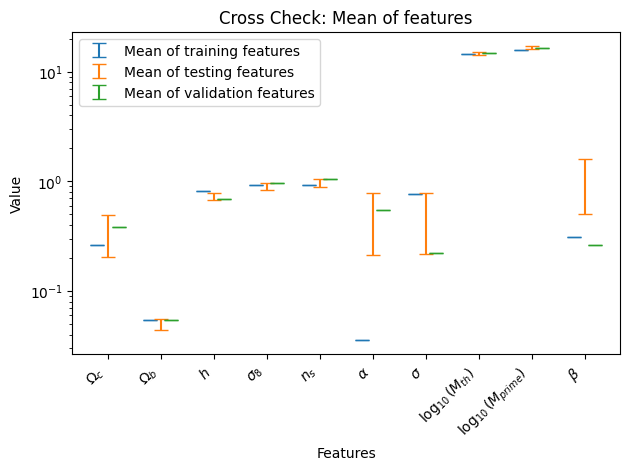

In [19]:
x_pos = np.arange(len(feature_keys))  # numerische Positionen für die x-Werte
offset = 0.2  # Abstand, um die Features ein bisschen zu verschieben

fig, axes = plt.subplots()

axes.set_xlabel('Features')
axes.set_ylabel('Value')
axes.set_title('Cross Check: Mean of features')

# Optional: Y-Achse logarithmisch
axes.set_xscale('linear')
axes.set_yscale('log')

# Training Features
axes.errorbar(x_pos - offset, mean_training_features, 
              yerr=std_training_features, ls='none', 
              color='C0', label='Mean of training features', capsize=5)

# Testing Features
axes.errorbar(x_pos, mean_testing_features, 
              yerr=std_testing_features, ls='none', 
              color='C1', label='Mean of testing features', capsize=5)

# Validation Features
axes.errorbar(x_pos + offset, mean_validation_features, 
              yerr=std_validation_features, ls='none', 
              color='C2', label='Mean of validation features', capsize=5)

# Setze die Original-Feature-Namen als x-Achsen-Beschriftung
axes.set_xticks(x_pos)
axes.set_xticklabels(['$\\Omega_c$', '$\\Omega_b$', '$h$', '$\\sigma_8$', '$n_s$', '$\\alpha$', '$\\sigma$', '$\log_{10}(M_{th})$', '$\log_{10}(M_{prime})$', '$\\beta$' ])
plt.xticks(rotation=45, ha='right')

# Legende
axes.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Justiere den unteren Rand des Plots
plt.savefig('../Plots/CrossCheckFeatures.png', dpi=600)
plt.show()

feature_keys = ['Om_c', 'Om_b', 'h', 'sigma_8', 'n_s', 'alpha', 'sigma', 'Mth', 'Mprime', 'beta']

## Renaming

In [20]:
# features
train_targets=training_targets['targets']
test_targets=testing_targets['targets']
val_targets=validation_targets['targets']

## Rescaling
We are rescaling the features by the mean and standard deviation of the training features. Then, they are all scattering by 1 and have a mean value of 0.


In [21]:
# Calculate mean and standard deviation **only from the training data**
target_processing_vectors = {
    'mean': np.mean(test_targets, axis=1, keepdims=True),
    'sigma': np.std(test_targets, axis=1, keepdims=True)
}

# Ensure that no division by zero occurs
target_processing_vectors['sigma'][target_processing_vectors['sigma'] == 0] = 1  

# Preprocessing function
def preprocessing(targets, processing_vectors):
    return (targets - processing_vectors['mean']) / processing_vectors['sigma']

# Postprocessing function
def postprocessing(targets, processing_vectors):
    return targets * processing_vectors['sigma'] + processing_vectors['mean']

# Apply preprocessing to all data
train_targets_rescaled = preprocessing(train_targets, target_processing_vectors)
test_targets_rescaled = preprocessing(test_targets, target_processing_vectors)
val_targets_rescaled = preprocessing(val_targets, target_processing_vectors)

# JSON-compatible storage of the processing vectors
#serializable_processing_vectors = {key: value.tolist() for key, value in processing_vectors.items()}
#processing_out="../Emulators/NM_processing_vectors.json"
#with open(processing_out, "w") as json_file:
#    json.dump(serializable_processing_vectors, json_file)

# Check shapes after the transformation
print("Train Rescaled Shape:", train_targets_rescaled.shape)
print("Test Rescaled Shape:", test_targets_rescaled.shape)
print("Val Rescaled Shape:", val_targets_rescaled.shape)



Train Rescaled Shape: (3, 1, 50)
Test Rescaled Shape: (3, 999998, 50)
Val Rescaled Shape: (3, 1, 50)


In [22]:
mean_training_targets_rescaled = []
std_training_targets_rescaled = []

mean_testing_targets_rescaled = []
std_testing_targets_rescaled = []

mean_validation_targets_rescaled = []
std_validation_targets_rescaled = []

# Calculate mean and standard deviation for rescaled training targets
for i in range(len(train_targets_rescaled)):  # for all 3-Halo terms
    halo_data_rescaled = np.array(train_targets_rescaled[i])

    mean = np.mean(halo_data_rescaled, axis=0)  # mean over complete rescaled training sample for every k-value
    std = np.std(halo_data_rescaled, axis=0)    # standard deviation over complete rescaled training sample for every k-value

    mean_training_targets_rescaled.append(mean)
    std_training_targets_rescaled.append(std)

# Calculate mean and standard deviation for rescaled testing targets
for i in range(len(test_targets_rescaled)):  # for all 3-Halo terms
    halo_data_rescaled = np.array(test_targets_rescaled[i])

    mean = np.mean(halo_data_rescaled, axis=0)  # mean over complete rescaled testing sample for every k-value
    std = np.std(halo_data_rescaled, axis=0)    # standard deviation over complete rescaled testing sample for every k-value

    mean_testing_targets_rescaled.append(mean)
    std_testing_targets_rescaled.append(std)

# Calculate mean and standard deviation for rescaled validation targets
for i in range(len(val_targets_rescaled)):  # for all 3-Halo terms
    halo_data_rescaled = np.array(val_targets_rescaled[i])

    mean = np.mean(halo_data_rescaled, axis=0)  # mean over complete rescaled validation sample for every k-value
    std = np.std(halo_data_rescaled, axis=0)    # standard deviation over complete rescaled validation sample for every k-value

    mean_validation_targets_rescaled.append(mean)
    std_validation_targets_rescaled.append(std)

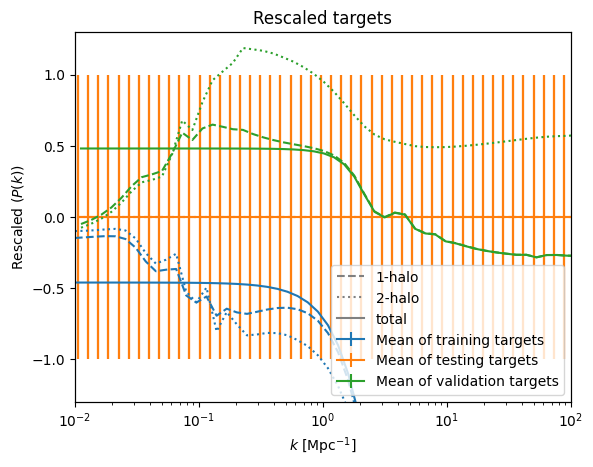

In [23]:
fig, axes=plt.subplots()
#axes.loglog(ks, Pk_lin, color='k', label='linear')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'Rescaled $(P(k))$')
plt.title('Rescaled targets')

ax2=axes.twinx()
ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='grey')
ax2.set_yticks([])



plt.errorbar(ks,mean_training_targets_rescaled[0], 
             yerr=std_training_targets_rescaled[0], color='C0', label='Mean of training targets')
plt.errorbar(ks,mean_training_targets_rescaled[1], ls=':', 
             yerr=std_training_targets_rescaled[1], color='C0')
plt.errorbar(ks,mean_training_targets_rescaled[2], ls='--', 
             yerr=std_training_targets_rescaled[2], color='C0')

plt.errorbar(ks*1.06,mean_testing_targets_rescaled[0], 
             yerr=std_testing_targets_rescaled[0], color='C1', label='Mean of testing targets')
plt.errorbar(ks*1.06,mean_testing_targets_rescaled[1], ls=':', 
             yerr=std_testing_targets_rescaled[1], color='C1')
plt.errorbar(ks*1.06,mean_testing_targets_rescaled[2], ls='--', 
             yerr=std_testing_targets_rescaled[2], color='C1')

plt.errorbar(ks*1.12,mean_validation_targets_rescaled[0], 
             yerr=std_validation_targets_rescaled[0], color='C2', label='Mean of validation targets')
plt.errorbar(ks*1.12,mean_validation_targets_rescaled[1], ls=':', 
             yerr=std_validation_targets_rescaled[1], color='C2')
plt.errorbar(ks*1.12,mean_validation_targets_rescaled[2], ls='--', 
             yerr=std_validation_targets_rescaled[2], color='C2')

axes.set_ylim(-1.3, 1.3)
plt.xlim(1e-2,100)
plt.ylim(-1.3,1.3)
plt.xscale('log')
plt.legend()
plt.savefig('../Plots/RescaledTargets.png', dpi=600)

In [24]:
# Calculate mean and standard deviation **only from the training data**
feature_processing_vectors = {
    'mean': np.array(mean_testing_features).reshape(1, -1),
    'sigma': np.array(std_testing_features).reshape(1, -1)
}

# Ensure that no division by zero occurs
feature_processing_vectors['sigma'][feature_processing_vectors['sigma'] == 0] = 1  

# Preprocessing function
def preprocessing(features, processing_vectors):
    return (features - processing_vectors['mean']) / processing_vectors['sigma']

# Postprocessing function
def postprocessing(features, processing_vectors):
    return features * processing_vectors['sigma'] + processing_vectors['mean']

# Apply preprocessing to all data
train_features_rescaled = preprocessing(training_features, feature_processing_vectors)
test_features_rescaled = preprocessing(testing_features, feature_processing_vectors)
val_features_rescaled = preprocessing(validation_features, feature_processing_vectors)

# JSON-compatible storage of the processing vectors
#serializable_processing_vectors = {key: value.tolist() for key, value in processing_vectors.items()}
#processing_out="../Emulators/NM_processing_vectors.json"
#with open(processing_out, "w") as json_file:
#    json.dump(serializable_processing_vectors, json_file)

# Check shapes after the transformation
print("Train Rescaled Shape:", train_features_rescaled.shape)
print("Test Rescaled Shape:", test_features_rescaled.shape)
print("Val Rescaled Shape:", val_features_rescaled.shape)



Train Rescaled Shape: (1, 10)
Test Rescaled Shape: (999998, 10)
Val Rescaled Shape: (1, 10)


In [25]:


mean_training_features_rescaled = []
std_training_features_rescaled = []

mean_testing_features_rescaled = []
std_testing_features_rescaled = []

mean_validation_features_rescaled = []
std_validation_features_rescaled = []


# Calculate mean and standard deviation for training features
for i in range(len(train_features_rescaled[0])):  # for all 3-Halo terms
    feature_parameter = np.array(train_features_rescaled[:,i])
    
    mean = np.mean(feature_parameter, axis=0)  # mean over complete training sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete training sample for every k-value
    mean_training_features_rescaled.append(mean)
    std_training_features_rescaled.append(std)

# Calculate mean and standard deviation for testing features
for i in range(len(test_features_rescaled[0])):  # for all 3-Halo terms
    feature_parameter = np.array(test_features_rescaled[:,i])

    mean = np.mean(feature_parameter, axis=0) # mean over complete testing sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete testing sample for every k-value

    mean_testing_features_rescaled.append(mean)
    std_testing_features_rescaled.append(std)

# Calculate mean and standard deviation for validation features
for i in range(len(val_features_rescaled[0])):  # for all 3-Halo terms
    feature_parameter = np.array(val_features_rescaled[:,i])

    mean = np.mean(feature_parameter, axis=0)  # mean over complete validation sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete validation sample for every k-value

    mean_validation_features_rescaled.append(mean)
    std_validation_features_rescaled.append(std)

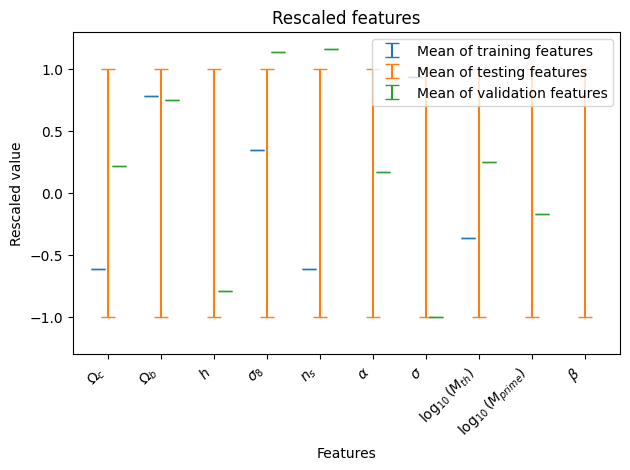

In [26]:
x_pos = np.arange(len(feature_keys))  # numerische Positionen für die x-Werte
offset = 0.2  # Abstand, um die Features ein bisschen zu verschieben

fig, axes = plt.subplots()

axes.set_xlabel('Features')
axes.set_ylabel('Rescaled value')
axes.set_title('Rescaled features')

# Optional: Y-Achse logarithmisch
axes.set_xscale('linear')
axes.set_yscale('linear')

# Training Features
axes.errorbar(x_pos - offset, mean_training_features_rescaled, 
              yerr=std_training_features_rescaled, ls='none', 
              color='C0', label='Mean of training features', capsize=5)

# Testing Features
axes.errorbar(x_pos, mean_testing_features_rescaled, 
              yerr=std_testing_features_rescaled, ls='none', 
              color='C1', label='Mean of testing features', capsize=5)

# Validation Features
axes.errorbar(x_pos + offset, mean_validation_features_rescaled, 
              yerr=std_validation_features_rescaled, ls='none', 
              color='C2', label='Mean of validation features', capsize=5)

# Setze die Original-Feature-Namen als x-Achsen-Beschriftung
axes.set_xticks(x_pos)
axes.set_xticklabels(['$\\Omega_c$', '$\\Omega_b$', '$h$', '$\\sigma_8$', '$n_s$', '$\\alpha$', '$\\sigma$', '$\log_{10}(M_{th})$', '$\log_{10}(M_{prime})$', '$\\beta$' ])
plt.xticks(rotation=45, ha='right')


axes.set_ylim(-1.3, 1.3)
plt.ylim(-1.3,1.3)
# Legende
plt.legend()

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Justiere den unteren Rand des Plots
plt.savefig('../Plots/RescaledFeatures.png', dpi=600)
plt.show()

## NN training

### Define Model

Define Neural Network with following structure

### Set training hyperparameters
We set some hyperparameters: How many features are processed in one step (batch_size), how fast the gradient descent should happen (learning_Rate), after how many steps without improvement the learning should stop (patience_values) and what is the maximal number of learning steps (max_epochs).

We also set where to save the emulator

In [27]:
#restructuring of the arrays
train_targets_rescaled      = np.transpose(train_targets_rescaled, (1, 0, 2))
val_targets_rescaled  = np.transpose(val_targets_rescaled, (1, 0, 2))
test_targets_rescaled = np.transpose(test_targets_rescaled, (1, 0, 2))


In [28]:
#load
timestamp = '2025-06-15_02-54-08' 

model = keras.models.load_model(
    f'../NN_builds/NN_{timestamp}.keras',
    compile=False
)
model.compile(optimizer=RectifiedAdam(), loss='mse')

with open(f'../Traininghist/full_training_history_{timestamp}.json', 'r') as f:
    loaded_history = json.load(f)

In [29]:
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_526 (Dense)           (None, 416)               4576      
                                                                 
 dense_527 (Dense)           (None, 416)               173472    
                                                                 
 dense_528 (Dense)           (None, 416)               173472    
                                                                 
 dense_529 (Dense)           (None, 416)               173472    
                                                                 
 dense_530 (Dense)           (None, 416)               173472    
                                                                 
 dense_531 (Dense)           (None, 416)               173472    
                                                                 
 dense_532 (Dense)           (None, 416)             

1/1 [==============================] - 3s 3s/step - loss: 0.0019


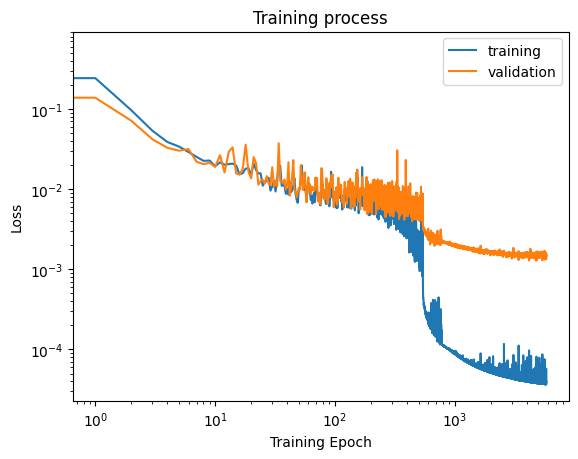

In [ ]:
loss = model.evaluate(train_features_rescaled, train_targets_rescaled.reshape((N_train, 150)))
val_loss = model.evaluate(val_features_rescaled, val_targets_rescaled.reshape((N_val, 150)))

fig, ax=plt.subplots()
ax.plot(loaded_history['loss'], label='training')
ax.plot(loaded_history['val_loss'], label='validation', alpha=1)
ax.set_ylabel('Loss')
ax.set_xlabel('Training Epoch')
ax.set_yscale('log')
ax.set_xscale('log')

#plt.savefig(f'../Plots/Loss_{timestamp}.pdf')

plt.legend()
plt.title("Training process")

plt.savefig(f'../Plots/FinalExamples/ExampleLoss.png', dpi=600)

In [69]:
#predicted data
emulated_training = np.array(model.predict(train_features_rescaled, batch_size=N_total))
emulated_testing = np.array(model.predict(test_features_rescaled, batch_size=N_total))

pred_training_targets= emulated_training.reshape(N_train, 3, 50).transpose(1, 0, 2)
postprocessed_pred_training_targets= postprocessing(pred_training_targets, target_processing_vectors)

pred_testing_targets= emulated_testing.reshape(N_test, 3, 50).transpose(1, 0, 2)
postprocessed_pred_testing_targets= postprocessing(pred_testing_targets, target_processing_vectors)

dataset= random.randrange(0, N_test)
print(dataset)


1/1 [==============================] - 12s 12s/step
115149


In [70]:
# Calculation of the difference
diff_1h = np.abs(postprocessed_pred_training_targets[0, :, :]/ train_targets[0,:,:] - 1)
diff_2h = np.abs(postprocessed_pred_training_targets[1, :, :] / train_targets[1,:,:] - 1)
diff_total = np.abs(postprocessed_pred_training_targets[2, :, :] / train_targets[2,:,:] - 1)

# Compute percentiles
percentiles_1h_train = np.zeros((4, diff_1h.shape[1]))
percentiles_2h_train = np.zeros((4, diff_2h.shape[1]))
percentiles_total_train = np.zeros((4, diff_total.shape[1]))

percentiles_1h_train[0] = np.percentile(diff_1h, 68, axis=0)
percentiles_1h_train[1] = np.percentile(diff_1h, 95, axis=0)
percentiles_1h_train[2] = np.percentile(diff_1h, 99, axis=0)
percentiles_1h_train[3] = np.percentile(diff_1h, 99.9, axis=0)

percentiles_2h_train[0] = np.percentile(diff_2h, 68, axis=0)
percentiles_2h_train[1] = np.percentile(diff_2h, 95, axis=0)
percentiles_2h_train[2] = np.percentile(diff_2h, 99, axis=0)
percentiles_2h_train[3] = np.percentile(diff_2h, 99.9, axis=0)

percentiles_total_train[0] = np.percentile(diff_total, 68, axis=0)
percentiles_total_train[1] = np.percentile(diff_total, 95, axis=0)
percentiles_total_train[2] = np.percentile(diff_total, 99, axis=0)
percentiles_total_train[3] = np.percentile(diff_total, 99.9, axis=0)

# Indices, bei denen die Differenz den 99. Perzentil überschreitet
indices_99 = np.argwhere(diff_1h >= percentiles_1h_train[None, 2])[:, 0]
indices_99 = np.argwhere(diff_2h >= percentiles_2h_train[None, 2])[:, 0]
indices_99 = np.argwhere(diff_total >= percentiles_total_train[None, 2])[:, 0]

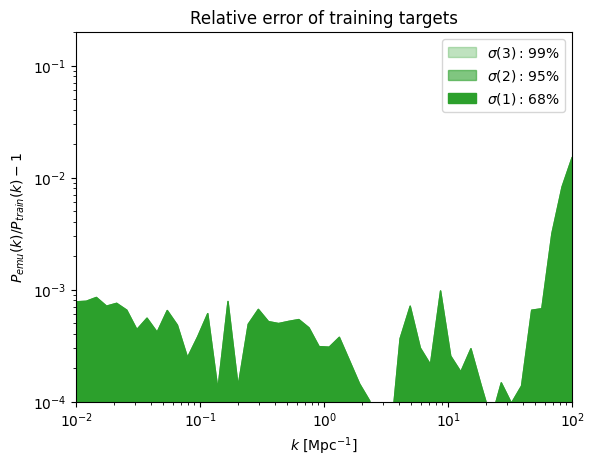

In [71]:
# do plot
fig, ax=plt.subplots()
#ax.fill_between(ks, 0, percentiles_1h[2,:], color = 'C0', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_1h[1,:], color = 'C0', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_1h[0,:], color = 'C0', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_2h[2,:], color = 'C1', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_2h[1,:], color = 'C1', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_2h[0,:], color = 'C1', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_total[3,:], color = 'C2', label = r'99.9\% percentile', alpha=0.1)
ax.fill_between(ks, 0, percentiles_total_train[2,:], color = 'C2', label = r'$\sigma (3): \, 99\%$', alpha=0.3)
ax.fill_between(ks, 0, percentiles_total_train[1,:], color = 'C2', label = r'$\sigma (2): \, 95\%$', alpha = 0.6)
ax.fill_between(ks, 0, percentiles_total_train[0,:], color = 'C2', label = r'$\sigma (1): \, 68\%$', alpha = 1)

ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='C0')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='C1')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='C2')


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-2, 100)
ax.set_ylim(1e-4, 2e-1)

ax.set_ylabel(r'$P_{emu}(k)/P_{train}(k)-1$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title('Relative error of training targets')

#plt.savefig(f'../Plots/Relativ_error{timestamp}.pdf')

plt.legend()

plt.savefig(f'../Plots/FinalExamples/relErrorTrain.png', dpi=600)


In [72]:
# Maximalen Fehler pro Sample (also Datensatz) bestimmen
train_max_error_per_sample = np.sum(np.abs(diff_total), axis=1)  # Shape (7500,)
worst_dataset_index = np.argmax(train_max_error_per_sample)      # worst_dataset_index liegt zwischen 0 und 7499

print(f"Schlechtester Datensatz: {worst_dataset_index}, Fehler: {train_max_error_per_sample[worst_dataset_index]:.4f}")


Schlechtester Datensatz: 0, Fehler: 0.0463


In [73]:
# Calculation of the difference
diff_1h = np.abs(postprocessed_pred_testing_targets[0, :, :]/ test_targets[0,:,:] - 1)
diff_2h = np.abs(postprocessed_pred_testing_targets[1, :, :] / test_targets[1,:,:] - 1)
diff_total = np.abs(postprocessed_pred_testing_targets[2, :, :] / test_targets[2,:,:] - 1)

# Compute percentiles
percentiles_1h_test = np.zeros((4, diff_1h.shape[1]))
percentiles_2h_test = np.zeros((4, diff_2h.shape[1]))
percentiles_total_test = np.zeros((4, diff_total.shape[1]))

percentiles_1h_test[0] = np.percentile(diff_1h, 68, axis=0)
percentiles_1h_test[1] = np.percentile(diff_1h, 95, axis=0)
percentiles_1h_test[2] = np.percentile(diff_1h, 99, axis=0)
percentiles_1h_test[3] = np.percentile(diff_1h, 99.9, axis=0)

percentiles_2h_test[0] = np.percentile(diff_2h, 68, axis=0)
percentiles_2h_test[1] = np.percentile(diff_2h, 95, axis=0)
percentiles_2h_test[2] = np.percentile(diff_2h, 99, axis=0)
percentiles_2h_test[3] = np.percentile(diff_2h, 99.9, axis=0)

percentiles_total_test[0] = np.percentile(diff_total, 68, axis=0)
percentiles_total_test[1] = np.percentile(diff_total, 95, axis=0)
percentiles_total_test[2] = np.percentile(diff_total, 99, axis=0)
percentiles_total_test[3] = np.percentile(diff_total, 99.9, axis=0)

# Indices, bei denen die Differenz den 99. Perzentil überschreitet
indices_99 = np.argwhere(diff_1h >= percentiles_1h_test[None, 2])[:, 0]
indices_99 = np.argwhere(diff_2h >= percentiles_2h_test[None, 2])[:, 0]
indices_99 = np.argwhere(diff_total >= percentiles_total_test[None, 2])[:, 0]

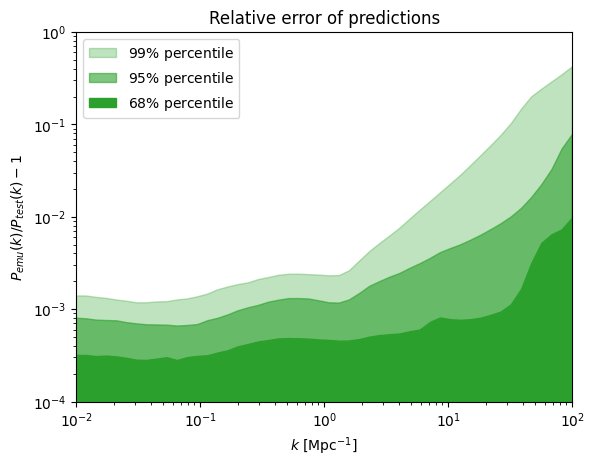

In [84]:
# do plot
fig, ax=plt.subplots()
#ax.fill_between(ks, 0, percentiles_1h[2,:], color = 'C0', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_1h[1,:], color = 'C0', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_1h[0,:], color = 'C0', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_2h[2,:], color = 'C1', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_2h[1,:], color = 'C1', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_2h[0,:], color = 'C1', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_total[3,:], color = 'C2', label = r'99.9\% percentile', alpha=0.1)
ax.fill_between(ks, 0, percentiles_total_test[2,:], color = 'C2', label = r'$99\%$ percentile', alpha=0.3)
ax.fill_between(ks, 0, percentiles_total_test[1,:], color = 'C2', label = r'$95\%$ percentile', alpha = 0.6)
ax.fill_between(ks, 0, percentiles_total_test[0,:], color = 'C2', label = r'$68\%$ percentile', alpha = 1)

ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='C0')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='C1')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='C2')


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-2, 100)
ax.set_ylim(1e-4, 1)

ax.set_ylabel(r'$P_{emu}(k)/P_{test}(k)-1$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title('Relative error of predictions')

#plt.savefig(f'../Plots/Relativ_error{timestamp}.pdf')

plt.legend()
plt.savefig(f'../Plots/FinalExamples/relErrorTest.png', dpi=600)

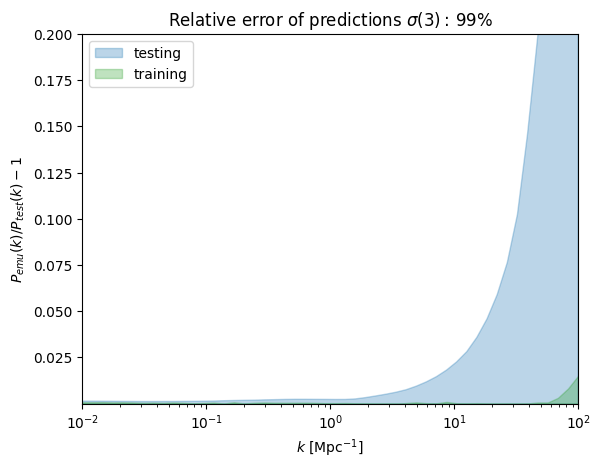

In [75]:
# do plot
fig, ax=plt.subplots()
#ax.fill_between(ks, 0, percentiles_1h[2,:], color = 'C0', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_1h[1,:], color = 'C0', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_1h[0,:], color = 'C0', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_2h[2,:], color = 'C1', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_2h[1,:], color = 'C1', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_2h[0,:], color = 'C1', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_total[3,:], color = 'C2', label = r'99.9\% percentile', alpha=0.1)
ax.fill_between(ks, 0, percentiles_total_test[2,:], color = 'C0', label = r'testing', alpha=0.3)


ax.fill_between(ks, 0, percentiles_total_train[2,:], color = 'C2', label = r'training', alpha=0.3)

ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='C0')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='C1')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='C2')


ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlim(1e-2, 100)
ax.set_ylim(1e-4, 2e-1)

ax.set_ylabel(r'$P_{emu}(k)/P_{test}(k)-1$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title(r'Relative error of predictions $\sigma (3): \, 99\%$')

plt.legend()
plt.savefig(f'../Plots/Examples/RelErrorAlphaFilteredTest.png', dpi=600)


In [76]:
# Maximalen Fehler pro Sample (also Datensatz) bestimmen
test_max_error_per_sample = np.sum(np.abs(diff_total), axis=1)  # Shape (7500,)
worst_dataset_index = np.argmax(test_max_error_per_sample)      # worst_dataset_index liegt zwischen 0 und 7499

print(f"Schlechtester Datensatz: {worst_dataset_index}, Fehler: {test_max_error_per_sample[worst_dataset_index]:.4f}")


Schlechtester Datensatz: 289797, Fehler: 237635.4269


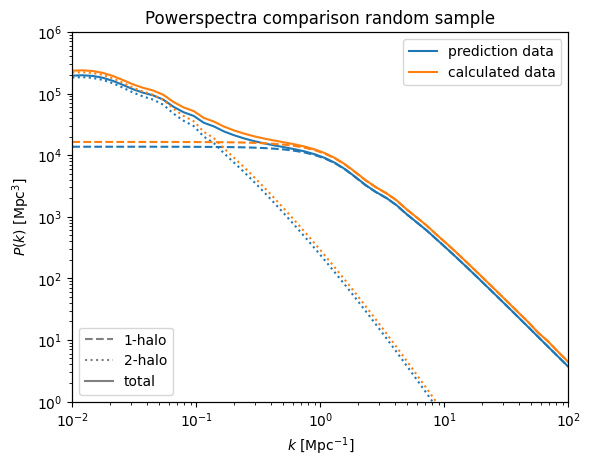

In [77]:
fig, axes=plt.subplots()
#axes.loglog(ks, Pk_lin, color='k', label='linear')

axes.loglog(ks, np.exp(postprocessed_pred_testing_targets[0][dataset]), color='C0', ls='--')
axes.loglog(ks, np.exp(postprocessed_pred_testing_targets[1][dataset]), color='C0', ls=':')
axes.loglog(ks, np.exp(postprocessed_pred_testing_targets[2][dataset]), color='C0', label='prediction data')

axes.loglog(ks, np.exp(test_targets[0][dataset])*1.2, color='C1', ls='--')
axes.loglog(ks, np.exp(test_targets[1][dataset])*1.2, color='C1', ls=':')
axes.loglog(ks, np.exp(test_targets[2][dataset])*1.2, color='C1', label='calculated data')


plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$P(k)$ [Mpc$^{3}$]')


ax2=axes.twinx()
ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='grey')



axes.legend()
ax2.legend(loc='lower left')
ax2.set_yticks([])
axes.set_title('Powerspectra comparison random sample')

axes.set_xlim(1e-2,100)
axes.set_ylim(1, 1e6)

plt.savefig(f'../Plots/FinalExamples/RandomPrediction.png', dpi=600)

In [78]:
are_equal = np.array_equal(postprocessed_pred_testing_targets[2], test_targets[2])
print("Arrays sind identisch:", are_equal)

mae = np.mean(np.abs(postprocessed_pred_testing_targets[2] - test_targets[2]))
print("Mittlerer absoluter Fehler (MAE):", mae)

correlation = np.corrcoef(postprocessed_pred_testing_targets[2].flatten(), test_targets[2].flatten())[0, 1]
print("Korrelationskoeffizient:", correlation)

relative_diff = np.abs((postprocessed_pred_testing_targets[2] - test_targets[2]) / postprocessed_pred_testing_targets[2])
mean_relative_diff = np.mean(relative_diff) * 100
print(f"Mittlere relative Abweichung: {mean_relative_diff:.2f}%")

Arrays sind identisch: False
Mittlerer absoluter Fehler (MAE): 0.005214413646071436
Korrelationskoeffizient: 0.9999758931907442
Mittlere relative Abweichung: 0.76%


Worst predicted Dataset

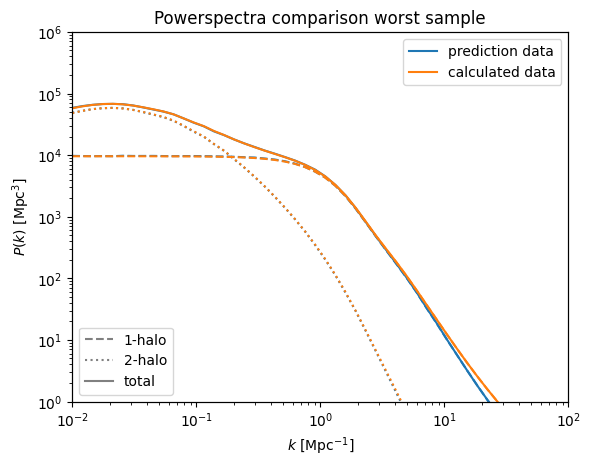

In [79]:
fig, axes = plt.subplots()

# Predicted Data
axes.loglog(ks, np.exp(postprocessed_pred_testing_targets[0, worst_dataset_index, :]), color='C0', ls='--')
axes.loglog(ks, np.exp(postprocessed_pred_testing_targets[1, worst_dataset_index, :]), color='C0', ls=':')
axes.loglog(ks, np.exp(postprocessed_pred_testing_targets[2, worst_dataset_index, :]), color='C0', label='prediction data')

# Real Data
axes.loglog(ks, np.exp(test_targets[0, worst_dataset_index, :]), color='C1', ls='--')
axes.loglog(ks, np.exp(test_targets[1, worst_dataset_index, :]), color='C1', ls=':')
axes.loglog(ks, np.exp(test_targets[2, worst_dataset_index, :]), color='C1', label='calculated data')

# Achsen usw.
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$P(k)$ [Mpc$^{3}$]')

ax2 = axes.twinx()
ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='grey')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='grey')

axes.legend()
ax2.legend(loc='lower left')
ax2.set_yticks([])
axes.set_title('Powerspectra comparison worst sample')

axes.set_xlim(1e-2, 100)
axes.set_ylim(1, 1e6)

plt.savefig(f'../Plots/FinalExamples/WorstPrediction.png', dpi=600)

plt.show()


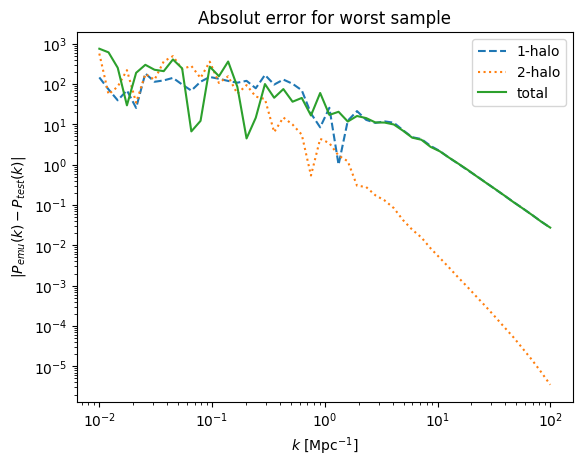

In [80]:
#Test Rescaled Shape: (3, 7500, 50)
# Berechne den absoluten Fehler für den schlechtesten Datensatz
abs_diff_1h_post = np.abs(np.exp(postprocessed_pred_testing_targets[0, worst_dataset_index, :]) - np.exp(test_targets[0, worst_dataset_index]))
abs_diff_2h_post = np.abs(np.exp(postprocessed_pred_testing_targets[1, worst_dataset_index, :]) - np.exp(test_targets[1, worst_dataset_index]))
abs_diff_total_post = np.abs(np.exp(postprocessed_pred_testing_targets[2, worst_dataset_index, :]) - np.exp(test_targets[2, worst_dataset_index]))

# Plot
fig, ax = plt.subplots()

ax.plot(ks, abs_diff_1h_post, ls='--', color='C0', label='1-halo')
ax.plot(ks, abs_diff_2h_post, ls=':', color='C1', label='2-halo')
ax.plot(ks, abs_diff_total_post, ls='-', color='C2', label='total')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$|P_{emu}(k) - P_{test}(k)|$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title(f'Absolut error for worst sample')

ax.legend()

plt.show()


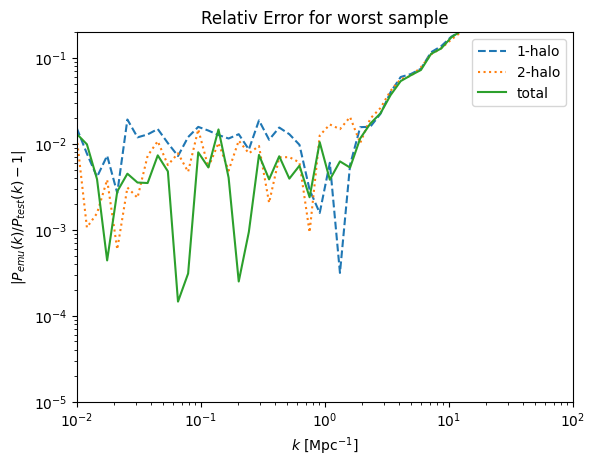

In [81]:
# Berechne die relative Abweichung für den schlechtesten Datensatz
rel_diff_1h = np.abs(np.exp(postprocessed_pred_testing_targets[0, worst_dataset_index, :]) / np.exp(test_targets[0, worst_dataset_index]) - 1)
rel_diff_2h = np.abs(np.exp(postprocessed_pred_testing_targets[1, worst_dataset_index, :]) / np.exp(test_targets[1, worst_dataset_index]) - 1)
rel_diff_total = np.abs(np.exp(postprocessed_pred_testing_targets[2, worst_dataset_index, :]) / np.exp(test_targets[2, worst_dataset_index]) - 1)

# Plot
fig, ax = plt.subplots()

ax.plot(ks, rel_diff_1h, ls='--', color='C0', label='1-halo')
ax.plot(ks, rel_diff_2h, ls=':', color='C1', label='2-halo')
ax.plot(ks, rel_diff_total, ls='-', color='C2', label='total')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-2, 100)
ax.set_ylim(1e-5, 2e-1)

ax.set_ylabel(r'$|P_{emu}(k)/P_{test}(k)-1|$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title(f'Relativ Error for worst sample')

ax.legend()
plt.savefig(f'../Plots/Examples/WorstPredctionRelError.png', dpi=600)
plt.show()

In [82]:
log_indices = [7, 8]  # Die Indizes, die zuvor log-transformiert wurden

# Rücktransformation per 10er-Potenz
training_features[:, log_indices] = 10 ** training_features[:, log_indices]
validation_features[:, log_indices] = 10 ** validation_features[:, log_indices]
testing_features[:, log_indices] = 10 ** testing_features[:, log_indices]

In [83]:
# Beispielhafte Dimensionen
N_params = testing_features.shape[1]
param_names = [r'$\Omega_c$', r'$\Omega_b$', r'$h$', r'$\sigma_8$', r'$n_s$', r'$\alpha$', r'$\sigma$', r'$M_{th}$', r'$M_{prime}$', r'$\beta$']

# Subplots nur untere Dreiecksmatrix + Diagonale
fig, axes = plt.subplots(N_params, N_params, figsize=(20, 20))
fig.suptitle(r"Parameter space with error of testing predictions", fontsize=22)

for i in range(N_params):
    for j in range(N_params):
        ax = axes[i, j]
        
        if i < j:
            ax.set_visible(False)
            continue
        
        elif i == j:
            ax.hist(testing_features[:, i], bins=30, color="gray", alpha=0.7)
        
        else:
            sc = ax.scatter(testing_features[:, j],
                            testing_features[:, i],
                            s=50 * test_max_error_per_sample / np.max(test_max_error_per_sample),
                            c=test_max_error_per_sample,
                            cmap="viridis", alpha=0.6, edgecolor="k", linewidth=0.2)
        
        if i == N_params - 1:
            ax.set_xlabel(param_names[j], fontsize=20)
        else:
            ax.set_xticks([])
        
        if j == 0:
            ax.set_ylabel(param_names[i], fontsize=20)
        else:
            ax.set_yticks([])

# Layout & Farbskala
plt.subplots_adjust(wspace=0.11, hspace=0.11, right=0.95, top=0.93)
cbar_ax = fig.add_axes([0.96, 0.1, 0.015, 0.8])
plt.colorbar(sc, cax=cbar_ax, label="Error")

#plt.savefig(f'../Plots/Parameterspace_test_{timestamp}.pdf')
plt.savefig(f'../Plots/FinalExamples/ParameterspaceTest.png', dpi=900)

plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x73c1aebc93f0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x73c0a29f0f70> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Features filtered by alpha>0.1

In [ ]:
alpha_filter_train_features = training_features[:, 5] > 0.1
alpha_filter_test_features = testing_features[:, 5] > 0.1
removed_indices_train = np.where(~alpha_filter_train_features)[0]
removed_indices_test = np.where(~alpha_filter_test_features)[0]
alpha_filtered_train_features = np.delete(training_features, removed_indices_train, axis=0)
alpha_filtered_test_features = np.delete(testing_features, removed_indices_test, axis=0)
alpha_filtered_train_targets = np.delete(train_targets, removed_indices_train, axis=1)
alpha_filtered_test_targets = np.delete(test_targets, removed_indices_test, axis=1)
postprocessed_pred_training_targets_alpha_filtered = np.delete(postprocessed_pred_training_targets, removed_indices_train, axis=1)
postprocessed_pred_testing_targets_alpha_filtered = np.delete(postprocessed_pred_testing_targets, removed_indices_test, axis=1)



In [ ]:
# Calculation of the difference
diff_1h = np.abs(postprocessed_pred_training_targets_alpha_filtered[0, :, :]/ alpha_filtered_train_targets[0,:,:] - 1)
diff_2h = np.abs(postprocessed_pred_training_targets_alpha_filtered[1, :, :] / alpha_filtered_train_targets[1,:,:] - 1)
diff_total = np.abs(postprocessed_pred_training_targets_alpha_filtered[2, :, :] / alpha_filtered_train_targets[2,:,:] - 1)

# Compute percentiles
percentiles_1h_train_alpha_filtered = np.zeros((4, diff_1h.shape[1]))
percentiles_2h_train_alpha_filtered = np.zeros((4, diff_2h.shape[1]))
percentiles_total_train_alpha_filtered = np.zeros((4, diff_total.shape[1]))

percentiles_1h_train_alpha_filtered[0] = np.percentile(diff_1h, 68, axis=0)
percentiles_1h_train_alpha_filtered[1] = np.percentile(diff_1h, 95, axis=0)
percentiles_1h_train_alpha_filtered[2] = np.percentile(diff_1h, 99, axis=0)
percentiles_1h_train_alpha_filtered[3] = np.percentile(diff_1h, 99.9, axis=0)

percentiles_2h_train_alpha_filtered[0] = np.percentile(diff_2h, 68, axis=0)
percentiles_2h_train_alpha_filtered[1] = np.percentile(diff_2h, 95, axis=0)
percentiles_2h_train_alpha_filtered[2] = np.percentile(diff_2h, 99, axis=0)
percentiles_2h_train_alpha_filtered[3] = np.percentile(diff_2h, 99.9, axis=0)

percentiles_total_train_alpha_filtered[0] = np.percentile(diff_total, 68, axis=0)
percentiles_total_train_alpha_filtered[1] = np.percentile(diff_total, 95, axis=0)
percentiles_total_train_alpha_filtered[2] = np.percentile(diff_total, 99, axis=0)
percentiles_total_train_alpha_filtered[3] = np.percentile(diff_total, 99.9, axis=0)

# Indices, bei denen die Differenz den 99. Perzentil überschreitet
indices_99 = np.argwhere(diff_1h >= percentiles_1h_train_alpha_filtered[None, 2])[:, 0]
indices_99 = np.argwhere(diff_2h >= percentiles_2h_train_alpha_filtered[None, 2])[:, 0]
indices_99 = np.argwhere(diff_total >= percentiles_total_train_alpha_filtered[None, 2])[:, 0]

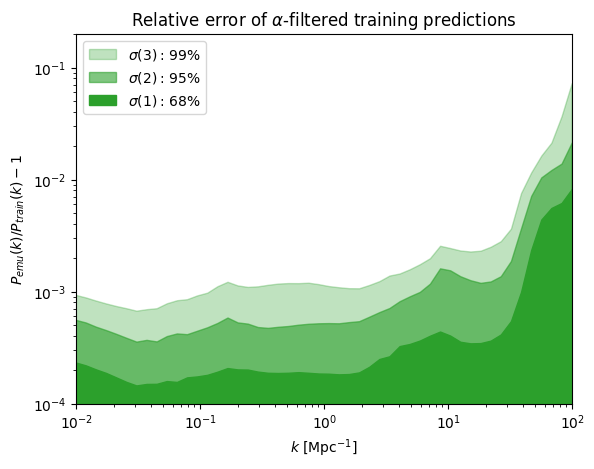

In [ ]:
# do plot
fig, ax=plt.subplots()
#ax.fill_between(ks, 0, percentiles_1h[2,:], color = 'C0', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_1h[1,:], color = 'C0', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_1h[0,:], color = 'C0', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_2h[2,:], color = 'C1', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_2h[1,:], color = 'C1', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_2h[0,:], color = 'C1', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_total[3,:], color = 'C2', label = r'99.9\% percentile', alpha=0.1)
ax.fill_between(ks, 0, percentiles_total_train_alpha_filtered[2,:], color = 'C2', label = r'$\sigma (3): \, 99\%$', alpha=0.3)
ax.fill_between(ks, 0, percentiles_total_train_alpha_filtered[1,:], color = 'C2', label = r'$\sigma (2): \, 95\%$', alpha = 0.6)
ax.fill_between(ks, 0, percentiles_total_train_alpha_filtered[0,:], color = 'C2', label = r'$\sigma (1): \, 68\%$', alpha = 1)

ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='C0')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='C1')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='C2')


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-2, 100)
ax.set_ylim(1e-4, 2e-1)

ax.set_ylabel(r'$P_{emu}(k)/P_{train}(k)-1$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title(r'Relative error of $\alpha$-filtered training predictions')

plt.legend()
plt.savefig(f'../Plots/FinalExamples/RelErrorAlphaFilteredTrain.png', dpi=600)


In [ ]:
# Maximalen Fehler pro Sample (also Datensatz) bestimmen
train_max_error_per_sample = np.sum(np.abs(diff_total), axis=1)  # Shape (7500,)
worst_dataset_index = np.argmax(train_max_error_per_sample)      # worst_dataset_index liegt zwischen 0 und 7499

print(f"Schlechtester Datensatz: {worst_dataset_index}, Fehler: {train_max_error_per_sample[worst_dataset_index]:.4f}")


Schlechtester Datensatz: 30581, Fehler: 132.6365


In [ ]:
# Calculation of the difference
diff_1h = np.abs(postprocessed_pred_testing_targets_alpha_filtered[0, :, :]/ alpha_filtered_test_targets[0,:,:] - 1)
diff_2h = np.abs(postprocessed_pred_testing_targets_alpha_filtered[1, :, :] / alpha_filtered_test_targets[1,:,:] - 1)
diff_total = np.abs(postprocessed_pred_testing_targets_alpha_filtered[2, :, :] / alpha_filtered_test_targets[2,:,:] - 1)

# Compute percentiles
percentiles_1h_test_alpha_filtered = np.zeros((4, diff_1h.shape[1]))
percentiles_2h_test_alpha_filtered = np.zeros((4, diff_2h.shape[1]))
percentiles_total_test_alpha_filtered = np.zeros((4, diff_total.shape[1]))

percentiles_1h_test_alpha_filtered[0] = np.percentile(diff_1h, 68, axis=0)
percentiles_1h_test_alpha_filtered[1] = np.percentile(diff_1h, 95, axis=0)
percentiles_1h_test_alpha_filtered[2] = np.percentile(diff_1h, 99, axis=0)
percentiles_1h_test_alpha_filtered[3] = np.percentile(diff_1h, 99.9, axis=0)

percentiles_2h_test_alpha_filtered[0] = np.percentile(diff_2h, 68, axis=0)
percentiles_2h_test_alpha_filtered[1] = np.percentile(diff_2h, 95, axis=0)
percentiles_2h_test_alpha_filtered[2] = np.percentile(diff_2h, 99, axis=0)
percentiles_2h_test_alpha_filtered[3] = np.percentile(diff_2h, 99.9, axis=0)

percentiles_total_test_alpha_filtered[0] = np.percentile(diff_total, 68, axis=0)
percentiles_total_test_alpha_filtered[1] = np.percentile(diff_total, 95, axis=0)
percentiles_total_test_alpha_filtered[2] = np.percentile(diff_total, 99, axis=0)
percentiles_total_test_alpha_filtered[3] = np.percentile(diff_total, 99.9, axis=0)

# Indices, bei denen die Differenz den 99. Perzentil überschreitet
indices_99 = np.argwhere(diff_1h >= percentiles_1h_test_alpha_filtered[None, 2])[:, 0]
indices_99 = np.argwhere(diff_2h >= percentiles_2h_test_alpha_filtered[None, 2])[:, 0]
indices_99 = np.argwhere(diff_total >= percentiles_total_test_alpha_filtered[None, 2])[:, 0]

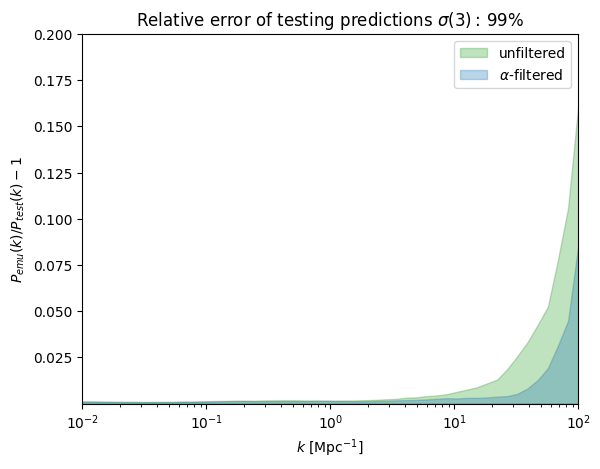

In [ ]:
# do plot
fig, ax=plt.subplots()
#ax.fill_between(ks, 0, percentiles_1h[2,:], color = 'C0', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_1h[1,:], color = 'C0', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_1h[0,:], color = 'C0', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_2h[2,:], color = 'C1', label = r'99\% percentile', alpha=0.3)
#ax.fill_between(ks, 0, percentiles_2h[1,:], color = 'C1', label = r'95\% percentile', alpha = 0.6)
#ax.fill_between(ks, 0, percentiles_2h[0,:], color = 'C1', label = r'68\% percentile', alpha = 1)

#ax.fill_between(ks, 0, percentiles_total[3,:], color = 'C2', label = r'99.9\% percentile', alpha=0.1)
ax.fill_between(ks, 0, percentiles_total_test[2,:], color = 'C2', label = r'unfiltered', alpha=0.3)


ax.fill_between(ks, 0, percentiles_total_test_alpha_filtered[2,:], color = 'C0', label = r'$\alpha$-filtered', alpha=0.3)

ax2.plot(np.NaN, np.NaN, ls='--', label='1-halo', color='C0')
ax2.plot(np.NaN, np.NaN, ls=':', label='2-halo', color='C1')
ax2.plot(np.NaN, np.NaN, ls='-', label='total', color='C2')


ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlim(1e-2, 100)
ax.set_ylim(1e-4, 2e-1)

ax.set_ylabel(r'$P_{emu}(k)/P_{test}(k)-1$')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_title(r'Relative error of testing predictions $\sigma (3): \, 99\%$')

plt.legend()
plt.savefig(f'../Plots/Examples/RelErrorAlphaFilteredTest.png', dpi=600)


In [ ]:
# Maximalen Fehler pro Sample (also Datensatz) bestimmen
test_max_error_per_sample = np.sum(np.abs(diff_total), axis=1)  # Shape (7500,)
worst_dataset_index = np.argmax(test_max_error_per_sample)      # worst_dataset_index liegt zwischen 0 und 7499

print(f"Schlechtester Datensatz: {worst_dataset_index}, Fehler: {test_max_error_per_sample[worst_dataset_index]:.4f}")


Schlechtester Datensatz: 3450, Fehler: 232.3347


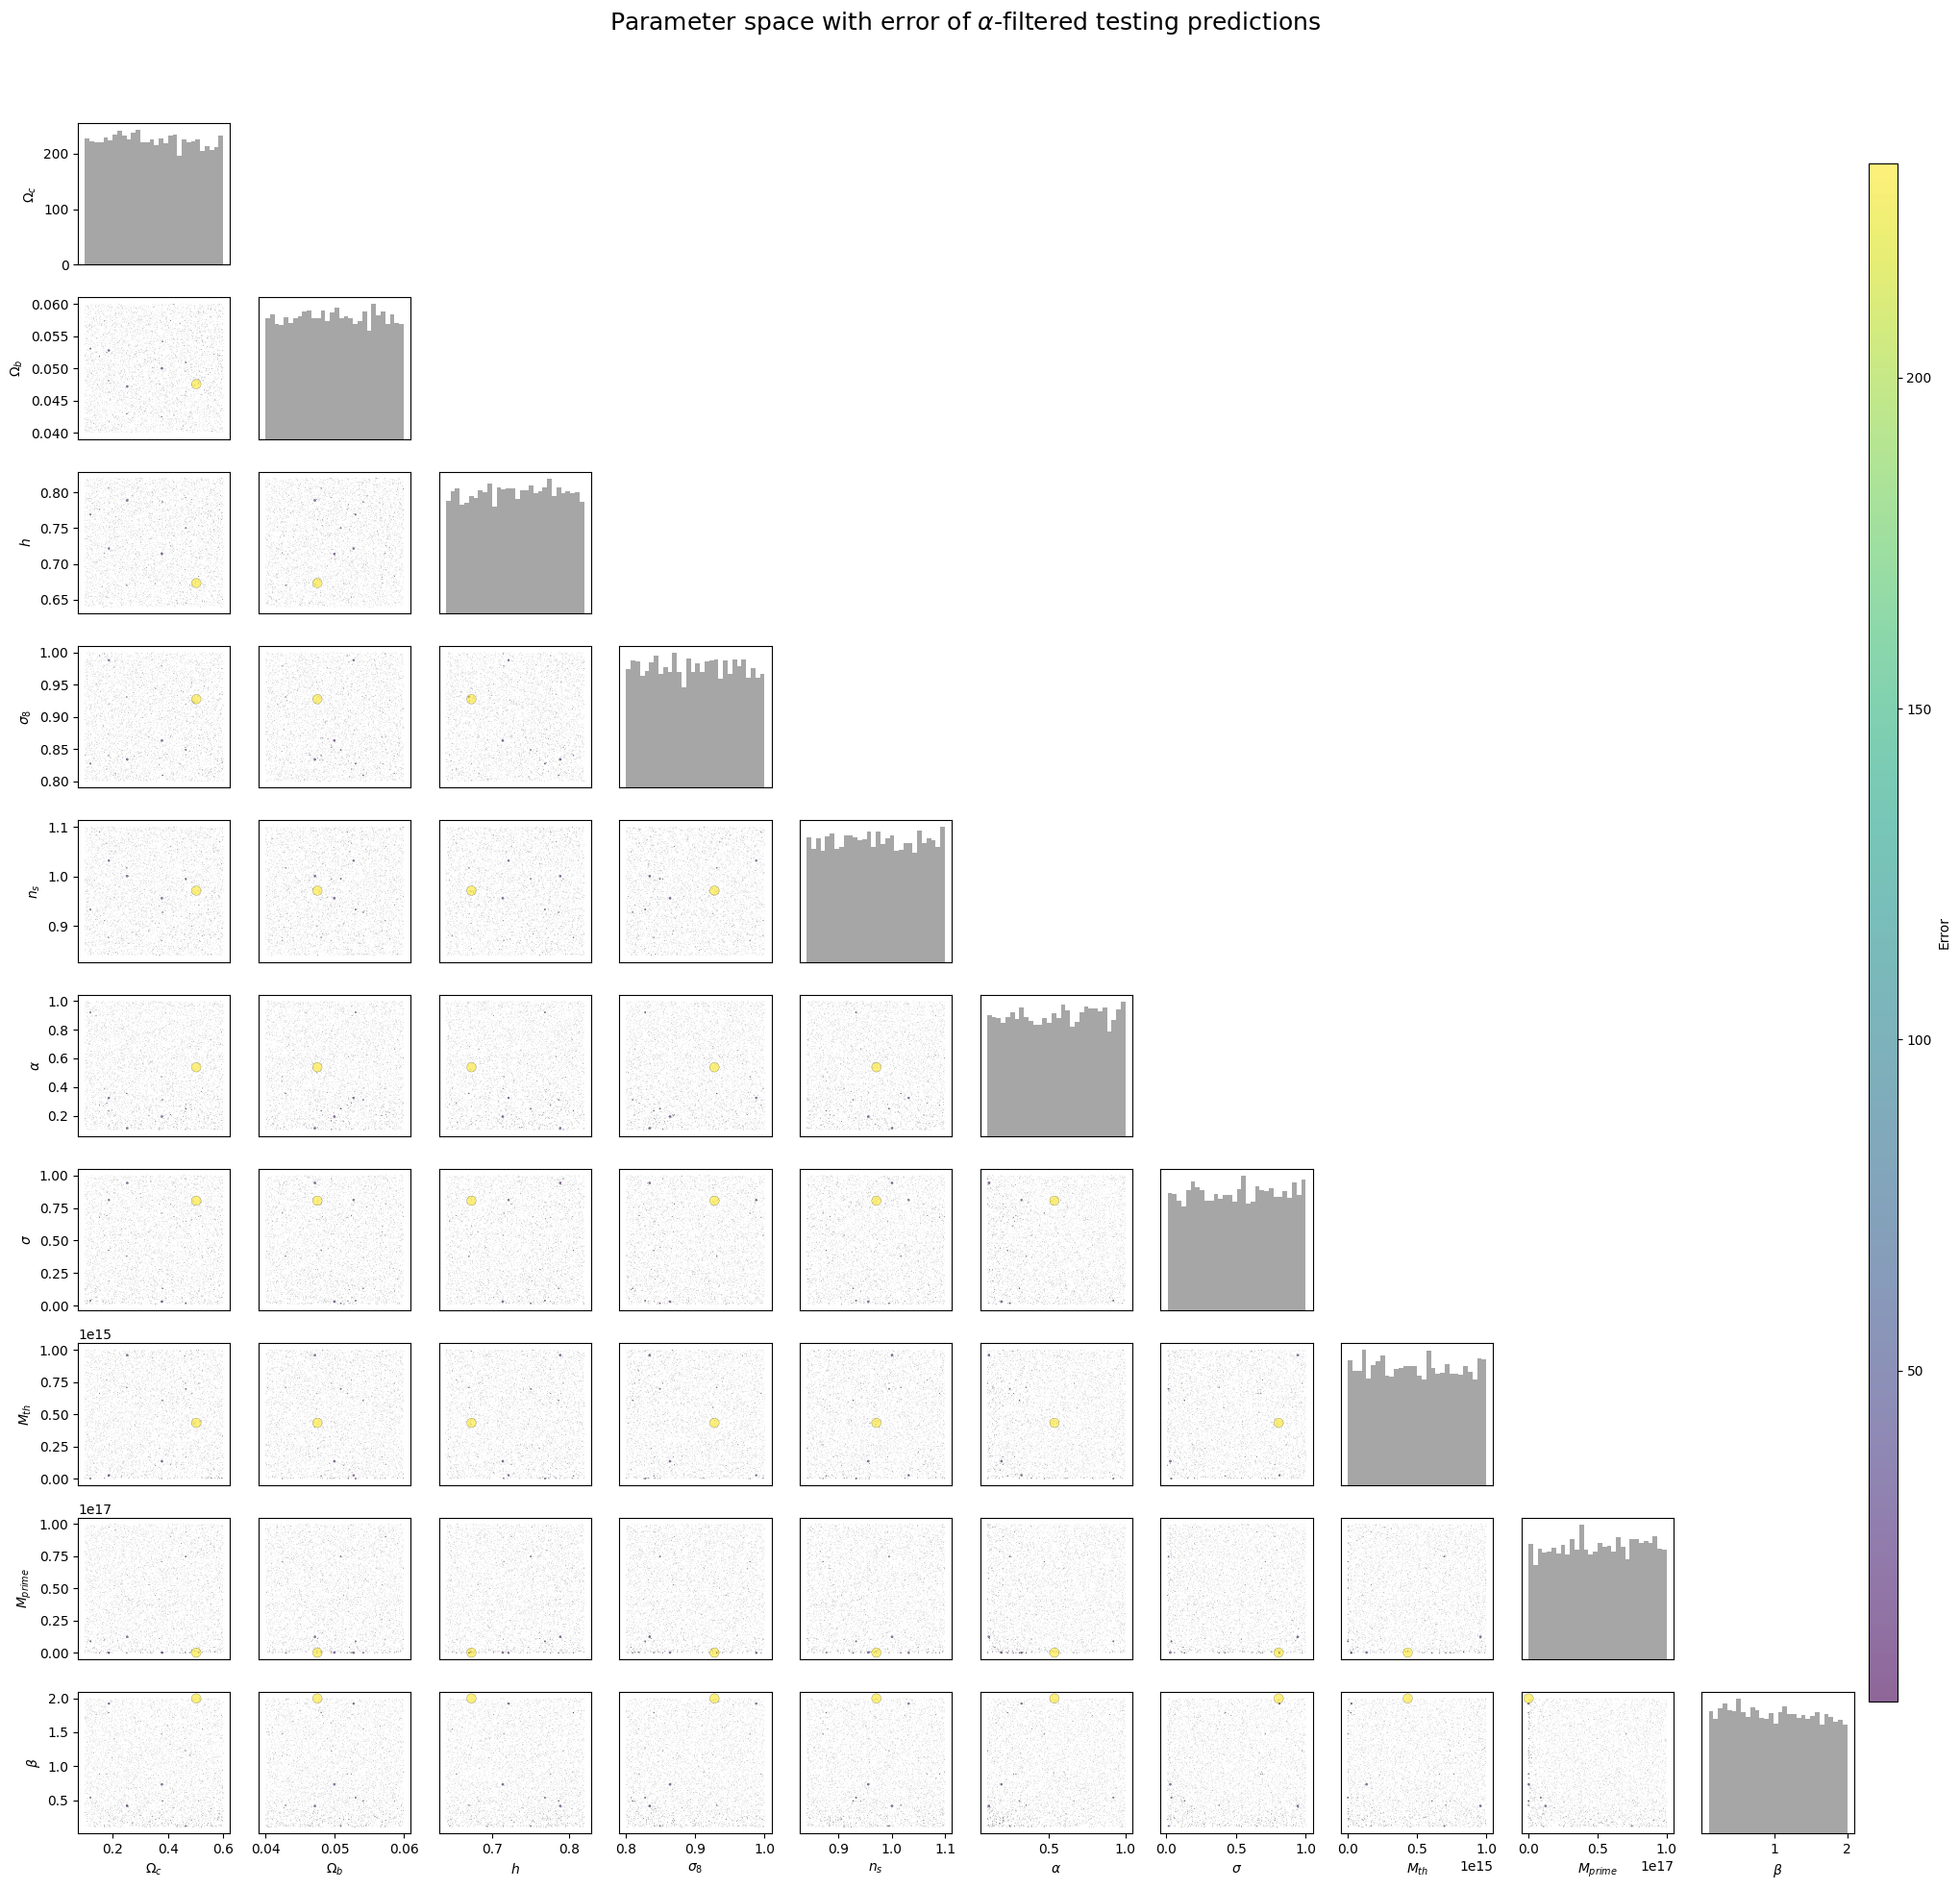

In [ ]:
# Beispielhafte Dimensionen
N_params = alpha_filtered_test_features.shape[1]
param_names = [r'$\Omega_c$', r'$\Omega_b$', r'$h$', r'$\sigma_8$', r'$n_s$', r'$\alpha$', r'$\sigma$', r'$M_{th}$', r'$M_{prime}$', r'$\beta$']

# Subplots nur untere Dreiecksmatrix + Diagonale
fig, axes = plt.subplots(N_params, N_params, figsize=(20, 20))
fig.suptitle(r"Parameter space with error of $\alpha$-filtered testing predictions", fontsize=18)

for i in range(N_params):
    for j in range(N_params):
        ax = axes[i, j]
        
        if i < j:
            ax.set_visible(False)
            continue
        
        elif i == j:
            ax.hist(alpha_filtered_test_features[:, i], bins=30, color="gray", alpha=0.7)
        
        else:
            sc = ax.scatter(alpha_filtered_test_features[:, j],
                            alpha_filtered_test_features[:, i],
                            s=50 * test_max_error_per_sample / np.max(test_max_error_per_sample),
                            c=test_max_error_per_sample,
                            cmap="viridis", alpha=0.6, edgecolor="k", linewidth=0.2)
        
        if i == N_params - 1:
            ax.set_xlabel(param_names[j])
        else:
            ax.set_xticks([])
        
        if j == 0:
            ax.set_ylabel(param_names[i])
        else:
            ax.set_yticks([])

# Layout & Farbskala
plt.tight_layout(rect=[0, 0, 0.97, 0.95])
cbar_ax = fig.add_axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(sc, cax=cbar_ax, label="Error")

#plt.savefig(f'../Plots/Parameterspace_test_{timestamp}_alpha_filtered.pdf')
plt.savefig(f'../Plots/FinalExamples/ParameterspaceTestAlphaFiltered.png', dpi=900)

plt.show()
